In [3]:
#Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



In [4]:
# Load both train and test datasets
train_dataset = pd.read_csv("train_data.csv")
test_dataset = pd.read_csv("test_data.csv")

In [5]:
#Check dataset
print("Train Dataset columns:", train_dataset.columns)
print("Test Dataset columns:", test_dataset.columns)

Train Dataset columns: Index(['event_id', 'time_to_tca', 'mission_id', 'risk', 'max_risk_estimate',
       'max_risk_scaling', 'miss_distance', 'relative_speed',
       'relative_position_r', 'relative_position_t',
       ...
       't_sigma_rdot', 'c_sigma_rdot', 't_sigma_tdot', 'c_sigma_tdot',
       't_sigma_ndot', 'c_sigma_ndot', 'F10', 'F3M', 'SSN', 'AP'],
      dtype='object', length=103)
Test Dataset columns: Index(['event_id', 'time_to_tca', 'mission_id', 'risk', 'max_risk_estimate',
       'max_risk_scaling', 'miss_distance', 'relative_speed',
       'relative_position_r', 'relative_position_t',
       ...
       't_sigma_rdot', 'c_sigma_rdot', 't_sigma_tdot', 'c_sigma_tdot',
       't_sigma_ndot', 'c_sigma_ndot', 'F10', 'F3M', 'SSN', 'AP'],
      dtype='object', length=103)


In [9]:
# Replace 'UNKNOWN' with NaN
train_dataset.replace('UNKNOWN', np.nan, inplace=True)
test_dataset.replace('UNKNOWN', np.nan, inplace=True)


In [11]:
#Data Preprocessing
#--------------------------------------------

# Remove unnecessary columns
drop_columns = ['event_id', 'mission_id', 'c_object_type']
train_dataset.drop(columns=[col for col in drop_columns if col in train_dataset.columns], inplace=True)
test_dataset.drop(columns=[col for col in drop_columns if col in test_dataset.columns], inplace=True)

# Make every column numeric
train_dataset = train_dataset.apply(pd.to_numeric, errors='coerce')
test_dataset = test_dataset.apply(pd.to_numeric, errors='coerce')

# Replace all inf values
train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
test_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Use the median to fill in the missing values
train_dataset.fillna(train_dataset.median(numeric_only=True), inplace=True)
test_dataset.fillna(test_dataset.median(numeric_only=True), inplace=True)

# Inspect risk value range and distribution
print("\n Risk (minimum or maximum:")
print("Minimum risk:", train_dataset['risk'].min())
print("Maximum risk:", train_dataset['risk'].max())

print("\nThe Risk value distribution:")
print(pd.cut(train_dataset['risk'], bins=10).value_counts())



 Risk (minimum or maximum:
Minimum risk: -30.0
Maximum risk: -1.4428538576816372

The Risk value distribution:
risk
(-30.029, -27.144]    69667
(-10.01, -7.154]      22852
(-7.154, -4.299]      21865
(-15.721, -12.866]    16481
(-12.866, -10.01]     14573
(-18.577, -15.721]     5718
(-21.433, -18.577]     4101
(-24.289, -21.433]     3455
(-27.144, -24.289]     2781
(-4.299, -1.443]       1141
Name: count, dtype: int64


In [13]:
#Target Label Creation & Balancing
#-----------------------------------------

# Binary classification (thresholding)
train_dataset['target'] = (train_dataset['risk'] > -10).astype(int)
test_dataset['target'] = (test_dataset['risk'] > -10).astype(int)

# Check the class distribution
print("\n The New Class Distribution with (threshold > -10):")
print(train_dataset['target'].value_counts())

# Under-sample class 0 to balance the dataset
class_0 = train_dataset[train_dataset['target'] == 0]
class_1 = train_dataset[train_dataset['target'] == 1]
train_dataset_balanced = pd.concat([class_0.sample(n=len(class_1), random_state=42), class_1], axis=0)



 The New Class Distribution with (threshold > -10):
target
0    116841
1     45793
Name: count, dtype: int64


In [15]:
# Split features & target
X_train = train_dataset_balanced.drop(columns=['risk', 'target'])
y_train = train_dataset_balanced['target']
X_test = test_dataset.drop(columns=['risk', 'target'])
y_test = test_dataset['target']

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
space_randomf_model = RandomForestClassifier(n_estimators=100, random_state=42)
space_randomf_model.fit(X_train_scaled, y_train)

# Predictions
y_predict = space_randomf_model.predict(X_test_scaled)


In [16]:
# Accuracy Calculation
accuracy = accuracy_score(y_test, y_predict)
print(f"\n Accuracy: {accuracy*100:.2f}%")


 Accuracy: 98.37%



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15252
           1       0.96      1.00      0.98      9232

    accuracy                           0.98     24484
   macro avg       0.98      0.99      0.98     24484
weighted avg       0.98      0.98      0.98     24484


 Confusion Matrix:
[[14898   354]
 [   45  9187]]

 ROC-AUC Score: 1.00


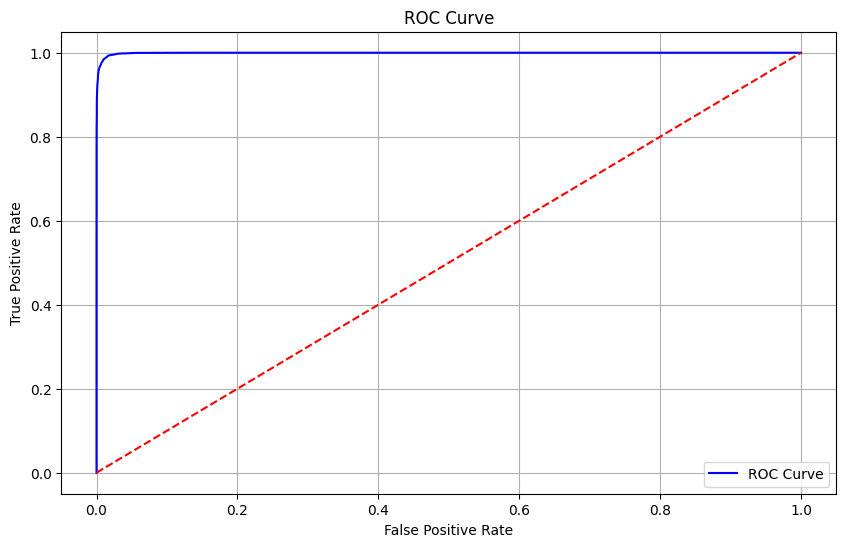

In [17]:
# Classification report 
print("\nClassification Report:")
print(classification_report(y_test, y_predict))

#confusion matrix
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_predict))

# ROC-AUC and Curve
if len(np.unique(y_test)) > 1:
    y_prob = space_randomf_model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\n ROC-AUC Score: {roc_auc:.2f}")

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, label='ROC Curve', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(" ROC-AUC skipped because only one class in test set.")